# ValidateTides

Ben Roberts, 2022

Perform a validtion of FVCOM water surface elevation output and NOAA water level observations. This is loosely based on a Python notebook I wrote in summer 2020 for validation of King County's Puget Sound Aquatic Biogeochemical Cycling (PSABC) model.

## Parameters

 * `station_info_file`: The shapefile containing names and coordinates of all the water elevation observation locations. This was generated with [GetTideData](GetTideData.ipynb) from NOAA CO-OPS data.
 * `data_path`: The path to the downloaded water elevation dataset for an individual station. "Name" is substituted with the name as given in `station_info_file`.
 * `model_output`: A glob pattern of all the NetCDF files from the hydrodynamic model run.
 * `start_date`: A plain text start date for the when the model run began, which will be read with pd.Timestamp.

In [1]:
station_info_file = "data/tides/station_info.shp"
data_path = "data/tides/{name}.csv.gz"
model_output = '/net/babaracus/home/benr/wqmodels/ssm/ictests/2014_hyd_3/OUTPUT/netcdf/ssm_*.nc'
run_name = '2014_hyd_3'
start_date = '2014-01-01'

import glob
import os.path as path
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from netCDF4 import Dataset
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

In [2]:
out_file = lambda name: path.join("notebook_outs", run_name + "_" + name)

Pull the model grid in UTM coordinates out of a netcdf output file and into a GeoDataFrame, indexed by node

Note that the node numbers in the GDF are zero-indexed, but we're only using it to reference 

In [3]:
fs = glob.glob(model_output)
fs.sort()
ds = Dataset(fs[0])
grid = gpd.GeoDataFrame({ "geometry": [Point(x, y) for x, y in zip(ds['x'][:], ds['y'][:])] }, crs='epsg:32610')
grid.head()

,geometry
0,POINT (413209.812 4916091.500)
1,POINT (400581.406 4916573.500)
2,POINT (390430.062 4916456.500)
3,POINT (380630.000 4918330.000)
4,POINT (375680.000 4925140.000)


Read the station info shapefile

In [4]:
station_info = gpd.read_file(station_info_file).set_index('id')
station_info

,name,geometry
id,,
9447130,Seattle,POINT (-122.33917 47.60194)
9446484,Tacoma,POINT (-122.41300 47.27000)
9444090,Port Angeles,POINT (-123.44000 48.12500)
9443090,Neah Bay,POINT (-124.60194 48.37028)


Perform the nearest spatial join between station_info and the model grid so we know what nodes to extract

In [5]:
j = gpd.tools.sjoin_nearest(station_info.to_crs('epsg:32610'), grid)
j

,name,geometry,index_right
id,,,
9447130,Seattle,POINT (549673.080 5272271.042),10749
9446484,Tacoma,POINT (544401.640 5235336.019),13541
9444090,Port Angeles,POINT (467257.231 5330287.222),3340
9443090,Neah Bay,POINT (381361.591 5358696.236),1339


Now, we can extract the water elevations and corresponding times

In [6]:
data = {
    'time': []
}
for f in fs:
    ds = Dataset(f)
    data['time'].extend(ds['time'][:])
    for s,row in j.iterrows():
        vals = ds['zeta'][:, row['index_right']]
        if row['name'] in data:
            data[row['name']].extend(vals)
        else:
            data[row['name']] = list(vals)
# Convert to UTC timezone with a manual TimeDelta, then apply it so the datetime is TZ-aware
idx = pd.to_datetime(pd.Timestamp(start_date) + pd.to_timedelta(data['time'], 'S') + pd.to_timedelta(8, 'h')).tz_localize('UTC')
df = pd.DataFrame(data, index=idx)
del df['time']
# Drop the initial elevations that were from the ramp-up time
df = df.loc[df.index.date - pd.to_timedelta(5, 'D') > df.index.date[0]]
df.head()

,Seattle,Tacoma,Port Angeles,Neah Bay
2014-01-07 00:00:00+00:00,-0.203026,-0.327631,0.913935,1.961261
2014-01-07 01:00:00+00:00,0.003556,-0.119866,0.957104,1.840404
2014-01-07 02:00:00+00:00,0.419896,0.330288,1.081182,1.530254
2014-01-07 03:00:00+00:00,1.049873,1.017061,1.224586,1.115987
2014-01-07 04:00:00+00:00,1.668912,1.676757,1.264696,0.653720


Generate the plot of how well each station matches the model

----- Relative errors as a percentage of the tidal range:
        Station  Error
0       Seattle    8.5
1        Tacoma    8.9
2  Port Angeles    7.9
3      Neah Bay    5.4


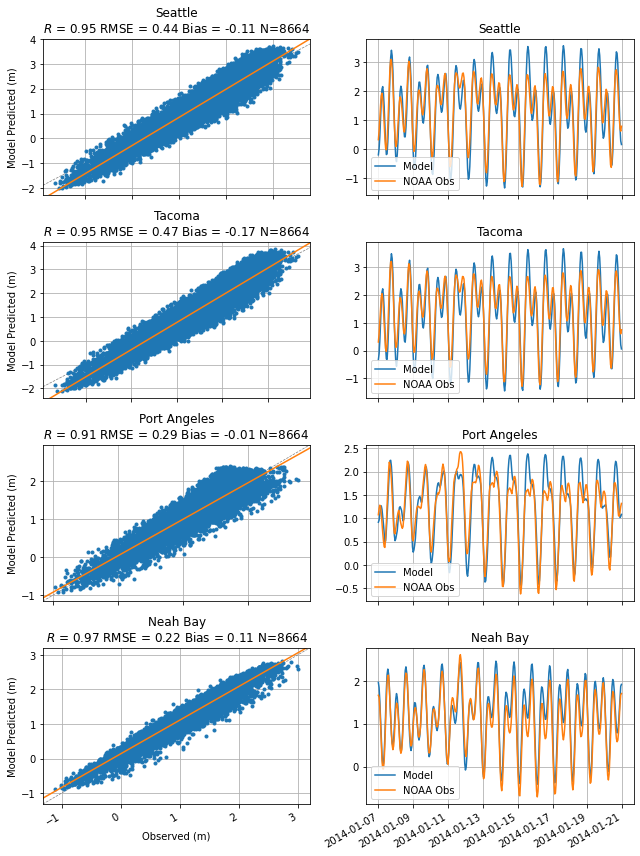

In [7]:
relative_errors = []
fig, axs = plt.subplots(len(df.columns), 2, figsize=(9,3*len(df.columns)))
plot_margin = 0.05

for c, fitax, tsax in zip(df.columns, axs[:,0], axs[:,1]):
    obsdata = pd.read_csv(data_path.format(name=c), parse_dates=[0], index_col=[0],
                          date_parser = lambda col: pd.to_datetime(col, utc=True))
    m = obsdata.merge(df[c], how='inner', left_index=True, right_index=True)

    observed = m[' Water Level']
    modeled = m[c]
    dates = m.index

    result = stats.linregress(observed, modeled)
    fit = lambda x: result.slope * x + result.intercept
    r = result.rvalue
    rmse = mean_squared_error(observed, modeled, squared=False)
    n = len(observed)
    bias = modeled.mean() - observed.mean()

    xrange = observed.max() - observed.min()
    relative_errors.append([c, np.round(rmse / xrange * 1000)/10])
    xmin = observed.min() - plot_margin * xrange
    xmax = observed.max() + plot_margin * xrange
    yrange = modeled.max() - modeled.min()
    ymin = min(modeled.min() - plot_margin * yrange, xmin)
    ymax = max(modeled.max() + plot_margin * yrange, xmax)
    xbound = np.array((xmin, xmax))
    fitax.plot(xbound, xbound, '--', color="gray", linewidth=.7)
    marker = "," if n > 10000 else "."
    fitax.plot(observed, modeled, marker)
    fitax.plot(xbound, fit(xbound))
    fitax.grid()
    fitax.set(title="%s\n$R$ = %.2f RMSE = %.2f Bias = %.2f N=%d" %
            (c, r, rmse, bias, n),
          ybound=(ymin,ymax), xbound=xbound, xlabel="Observed (m)",
          ylabel="Model Predicted (m)")
    
    # Plot the first two weeks of data
    tsax.plot(dates[:336], modeled[:336], label="Model")
    tsax.plot(dates[:336], observed[:336], label="NOAA Obs")
    tsax.set_title(c)
    tsax.grid()
    tsax.legend()
    fig.autofmt_xdate()
    
print("----- Relative errors as a percentage of the tidal range:")
print(pd.DataFrame(relative_errors, columns=["Station","Error"]))
plt.tight_layout()
fig.savefig(out_file("tide_validation.png"))